# APPM 5720 Biweekly Report - Part 1/2
### *Alexey Yermakov*
### *October 27 2022*

# Summary
For this report my main goal was to train a smaller model through distillation. I used the Fashion MNIST dataset and a simple densely connected neural network to show the practical benefits of distillation. In part 1 (this report), I use a multi-layer perceptron. In part 2, I use a convolutional neural network. I compare both models and have a discussion at the end of part 2.

# Main Content

First I import everything I'll be using and make sure my GPU is running.

In [1]:
# Make sure Torch is installed and our GPU is available
import torch
import numpy as np
from torch import permute, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import MaxNLocator

# Print matplotlibe plots inline
%matplotlib inline

# Check if GPU is available, though I don't use it in this notebook
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


Next, I create my MLP. This has 5 layers, between each is a ReLU activation function. Pretty simple. I also add the labels from Fashion MNIST and a few helpful functions `get_label` and `get_labels_acc` for plotting later in this notebook.

In [2]:
# Create our model
class NeuralNetwork(nn.Module):
    def __init__(self):
        # See https://realpython.com/python-super/ for what super does
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
        # Define labels
        self.labels = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

    # Standard forward
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    # Get label from self.labels and our logits
    def get_label(self, logits):
        pred_prob = nn.Softmax(dim=1)(logits)
        y_pred = pred_prob.argmax(1)
        return y_pred
    
    # Get labels and their normalized probability as an array for pretty plotting
    def get_labels_acc(self, x):
        logits = self.forward(x)
        logits = logits
        m = nn.Softmax(dim=1)
        sm = m(logits).cpu().numpy()[0]
        out = [(sm[i]*100, self.labels[i]) for i in range(len(sm))]
        srtd = sorted(out)
        return srtd
        
# Make our model
model1 = NeuralNetwork().to(device)

total_params = sum(p.numel() for p in model1.parameters())
print("Total Parameters:", total_params)

Total Parameters: 1195018


Next, I load my dataset. I added the `preprocess` command so that the images and labels get loaded to my GPU automatically during training. I also use batch sizes of 32 just because it's easy and good for training.

In [3]:
# Download and load dataset
base_dir = "/home/alexey/Datasets/"
batch_size = 32

training_data = datasets.FashionMNIST(
    root=base_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=base_dir,
    train=False,
    download=True,
    transform=ToTensor()
)

def preprocess(x, y):
    return x.to(device), y.to(device)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            # *b makes it so that the input to func is two variables: the images and the labels
            # yield is like return except it stops execution until the object is "grabbed"
            yield (self.func(*b)) 

train_dl1 = DataLoader(training_data, batch_size=batch_size, shuffle=False)
test_dl1 = DataLoader(test_data, batch_size=batch_size, shuffle=False)
            
train_dl2 = WrappedDataLoader(train_dl1, preprocess)
test_dl2 = WrappedDataLoader(test_dl1, preprocess)

Next, I define the learning rate and epochs. These hyperparameters were chosen to balance training time and effectiveness of results. I didn't really try to get the model to be the "best", since I just wanted to show distilliation.

In [4]:
# Set hyperparameters
learning_rate = 1e-3
epochs = 50
# Make our optimizer
loss_fn1 = nn.MSELoss() # MSE Loss since it supports one-hot encoding
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate) # AdamW since it's faster than SGD

Next, we define the training and testing loops. These have print statements in them so we can view progress during training.

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)*batch_size
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y = torch.nn.functional.one_hot(y, num_classes=10)
        y = y.to(torch.float32)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)*batch_size
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = torch.nn.functional.one_hot(y, num_classes=10)
            y = y.to(torch.float32)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == torch.argmax(y, dim=1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print("correct", 100*correct)
    print("loss", test_loss)
    return (100*correct, test_loss)

Now we can actually do some training! I'll save the running accuracy and loss so that I can plot them later.

In [ ]:
train_acc1 = list()
test_acc1 = list()
train_loss1 = list()
test_loss1 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop(train_dl2, model1, loss_fn1, optimizer1)
    
    acc, loss = test_loop(train_dl2, model1, loss_fn1)
    train_acc1.append(acc)
    train_loss1.append(loss)
    
    acc, loss = test_loop(test_dl2, model1, loss_fn1)
    test_acc1.append(acc)
    test_loss1.append(loss)
print("Done!")

Now let's see how well the model did in a nice visual!

In [7]:
def plot_train_test_acc_loss(train_acc, test_acc, train_loss, test_loss, file_name = "PLOT"):
    '''
    plot_train_test_acc

    Make a plot of training vs testing accuracy
    '''
    # Print minimum
    if False:
        print()
        print(f"Max training accuracy was at epoch {np.argmax(train_acc)+1:>04} : {train_acc[np.argmax(train_acc)]}")
        print(f"Max testing accuracy was at epoch  {np.argmax(test_acc)+1:>04} : {test_acc[np.argmax(test_acc)]}")
        print()
        print(f"Min training loss was at epoch {np.argmin(train_loss)+1:>04} : {train_loss[np.argmin(train_loss)]}")
        print(f"Min testing loss was at epoch  {np.argmin(test_loss)+1:>04} : {test_loss[np.argmin(test_loss)]}")

    # Make plot
    fig, ax = plt.subplots(1,2,figsize=(10,5), dpi=120, facecolor='white', tight_layout={'pad': 1})

    marker_style = dict(markersize = 6)

    ax[0].plot(list(range(1, len(train_acc)+1)), train_acc, linestyle='solid', marker='^', color='#d95319', label="Training Accuracy", **marker_style)
    ax[0].plot(list(range(1, len(test_acc)+1)), test_acc, linestyle='solid', marker='^', color='#0072bd', label="Testing Accuracy", **marker_style)

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    ax[0].legend(fontsize='small')

    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(list(range(1, len(train_loss)+1)), train_loss, linestyle='solid', marker='^', color='#d95319', label="Training Loss", **marker_style)
    ax[1].plot(list(range(1, len(test_loss)+1)), test_loss, linestyle='solid', marker='^', color='#0072bd', label="Testing Loss", **marker_style)

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')

    ax[1].legend(fontsize='small')

    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()


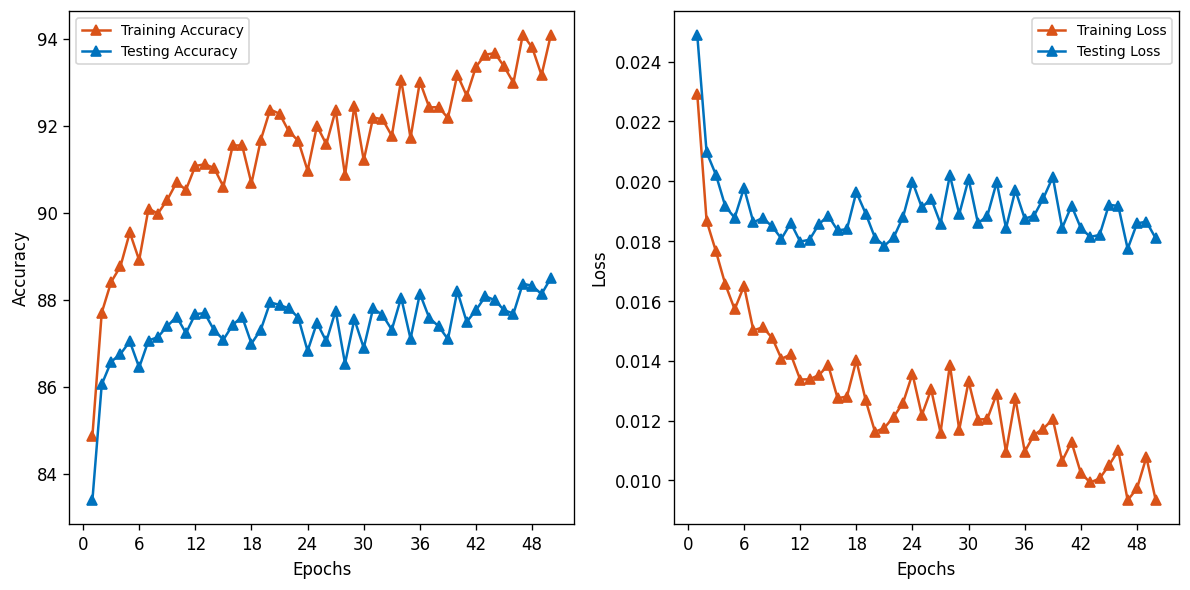

Max training accuracy: 94.09% at epoch 47
Max testing accuracy:  88.50% at epoch 50
Min training loss:     0.009332795268898674 at epoch 50
Min testing loss:      0.017740105328257212 at epoch 47


In [8]:
plot_train_test_acc_loss(train_acc1, test_acc1, train_loss1, test_loss1)
print(f"Max training accuracy: {max(train_acc1):2.2f}% at epoch {np.argmax(train_acc1)+1}")
print(f"Max testing accuracy:  {max(test_acc1):2.2f}% at epoch {np.argmax(test_acc1)+1}")
print(f"Min training loss:     {min(train_loss1)} at epoch {np.argmin(train_loss1)+1}")
print(f"Min testing loss:      {min(test_loss1)} at epoch {np.argmin(test_loss1)+1}")

Great! So our model works. Clearly, there is some overfitting going on since the training accuracy and loss get better much quicker than testing accuracy. This can be resolved by more regularization and now using an MLP. But again, we're not using an MLP for accuracy, but for knowledge distillation.

Let's see what kind of predictions our model makes:

Training data sample (not preprocessed for resnet):


/tmp/ipykernel_2074/2623568021.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  label = np.vstack(res)


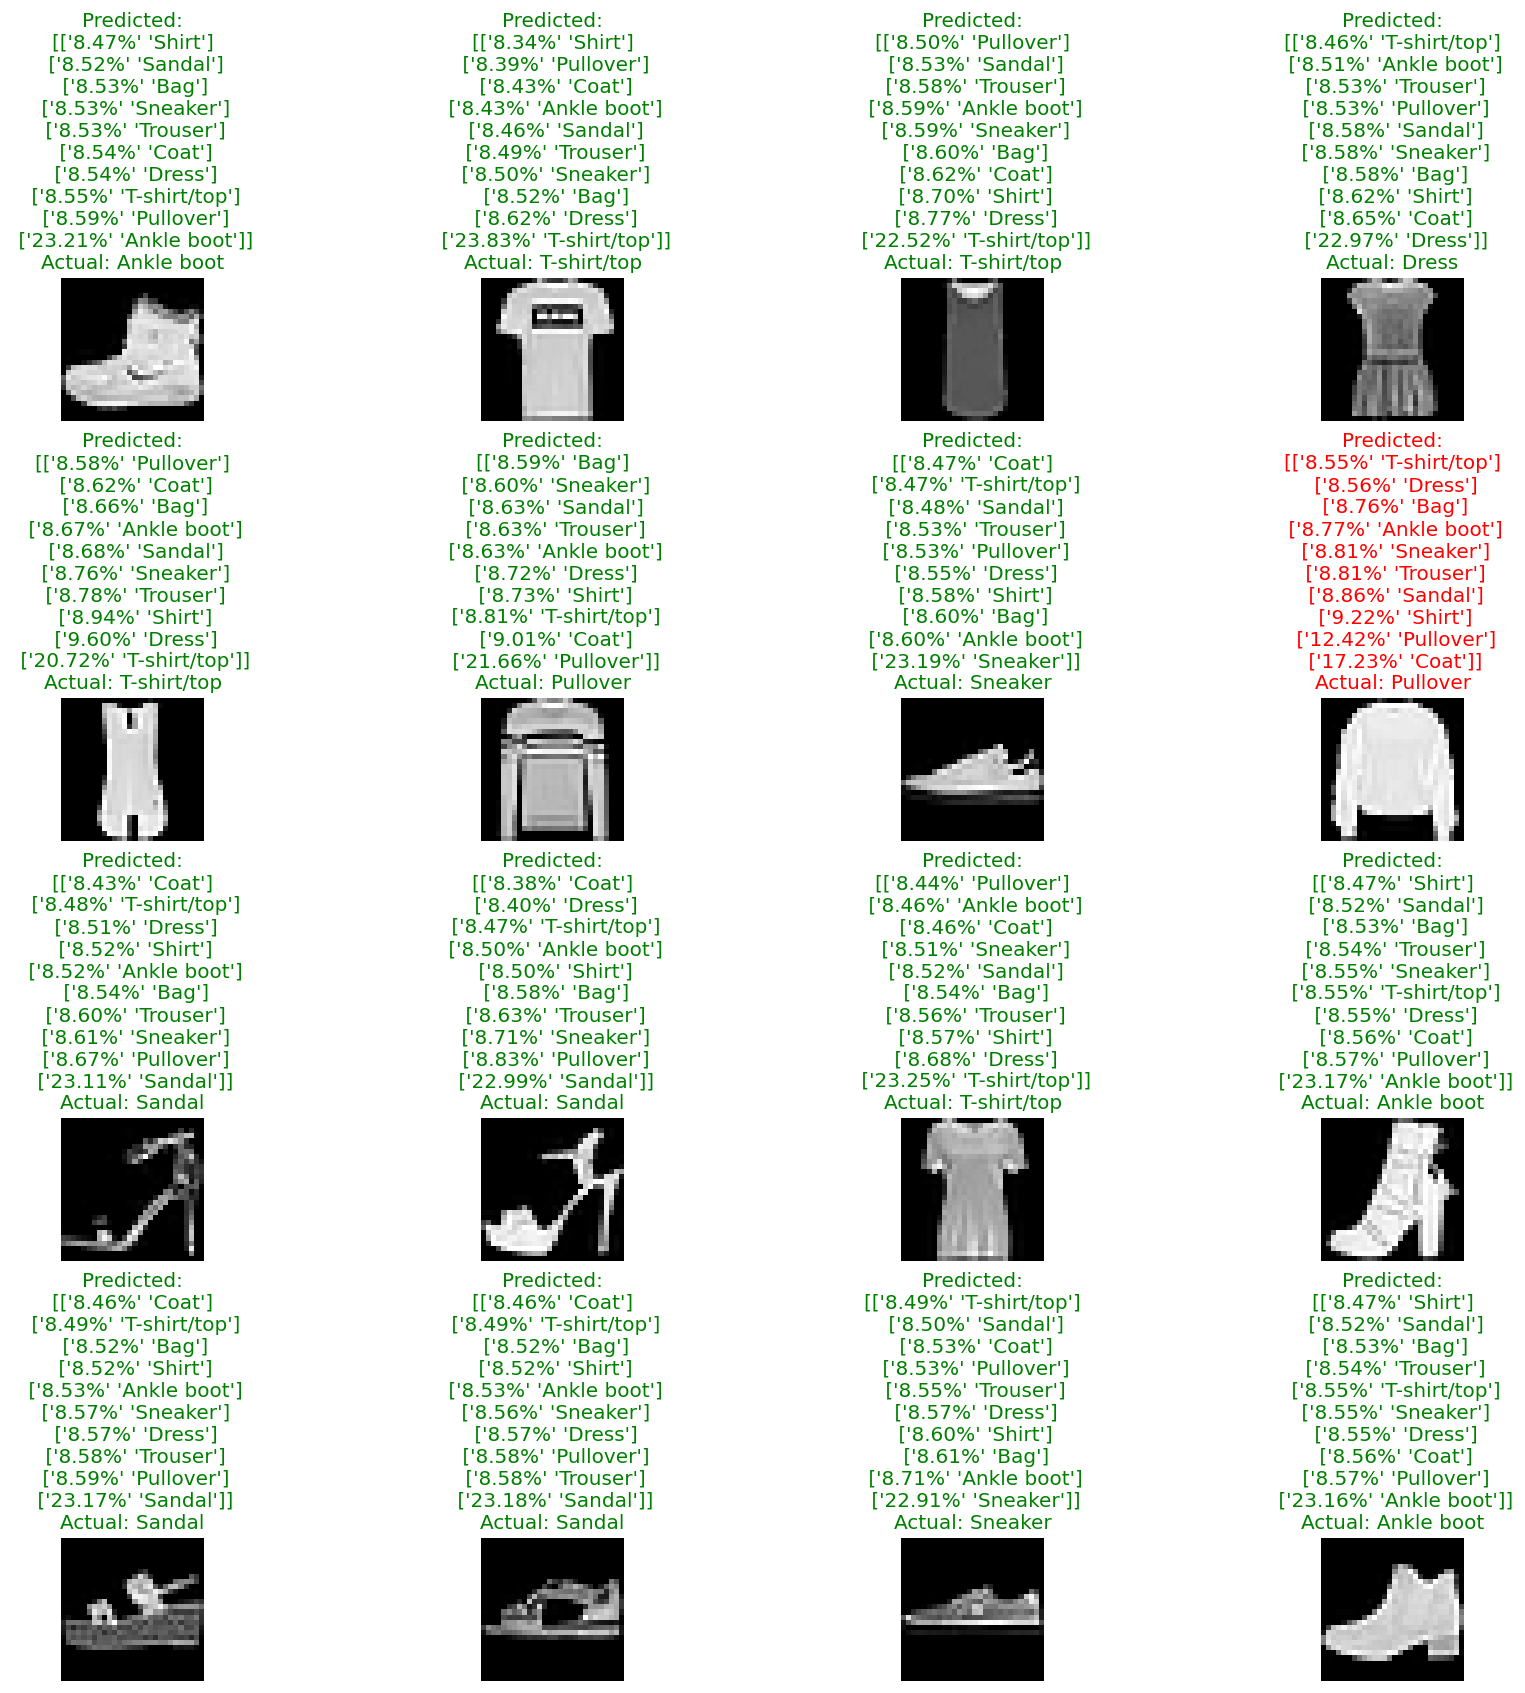

In [9]:
# Plot training data sample
print("Training data sample (not preprocessed for resnet):")
batch = next(iter(train_dl1))

# Create our figure as a grid
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(3.5*ncols,3.5*nrows), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
            image = batch[0][r*ncols+c]
            label_real = batch[1][r*ncols+c]
            label_real = model1.labels[label_real.item()]
            image_show = permute(image, (1,2,0)) # Change ordering of dimensions

            with torch.no_grad():
                res = model1.get_labels_acc(image.to(device))
                res = map(lambda tup: (f"{tup[0]:2.2f}%", tup[1]), res)
                label = np.vstack(res)

            ax = f1_axes[r][c]
            ax.set_axis_off()
            ax.set_title("Predicted:\n" + str(label) + f"\nActual: {label_real:s}",
                        fontdict = {'color': 'green' if label_real == label[-1][1] else 'red'})
            ax.imshow(np.asarray(image_show), cmap='gray')

plt.show()

Great! So our model seems to be doing pretty well. I'll refer to this diagram later when we've done some knowledge distillation.

Let's now define a much smaller model, with 3 layers instead of 5, and do knowledge distillation training. Here, instead of training on the true label I'll use the first model's predictions as the "true" label during training. The below code blocks are the same as above so I won't explain them.

In [10]:
# Create our model
class NeuralNetwork2(nn.Module):
    def __init__(self):
        # See https://realpython.com/python-super/
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(""),
            nn.Linear(512, 10),
        )
        
        # Define labels
        self.labels = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
    def get_label(self, logits):
        pred_prob = nn.Softmax(dim=1)(logits)
        y_pred = pred_prob.argmax(1)
        return y_pred
    
    # Get labels and their normalized probability
    def get_labels_acc(self, x):
        logits = self.forward(x)
        logits = logits
        m = nn.Softmax(dim=1)
        sm = m(logits).cpu().numpy()[0]
        out = [(sm[i]*100, self.labels[i]) for i in range(len(sm))]
        srtd = sorted(out)
        return srtd
        

model2 = NeuralNetwork2().to(device)

In [11]:
# Make our optimizer
loss_fn2 = nn.MSELoss() # MSE Loss since it supports one-hot encoding
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate) # AdamW since it's faster than SGD

In [12]:
def train_loop2(dataloader, model_in, model_distill, loss_fn, optimizer):
    size = len(dataloader)*batch_size
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model_in(X)
        y = model_distill(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
train_acc2 = list()
test_acc2 = list()
train_loss2 = list()
test_loss2 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop2(train_dl2, model2, model1, loss_fn2, optimizer2)
    
    acc, loss = test_loop(train_dl2, model2, loss_fn2)
    train_acc2.append(acc)
    train_loss2.append(loss)
    
    acc, loss = test_loop(test_dl2, model2, loss_fn2)
    test_acc2.append(acc)
    test_loss2.append(loss)
print("Done!")

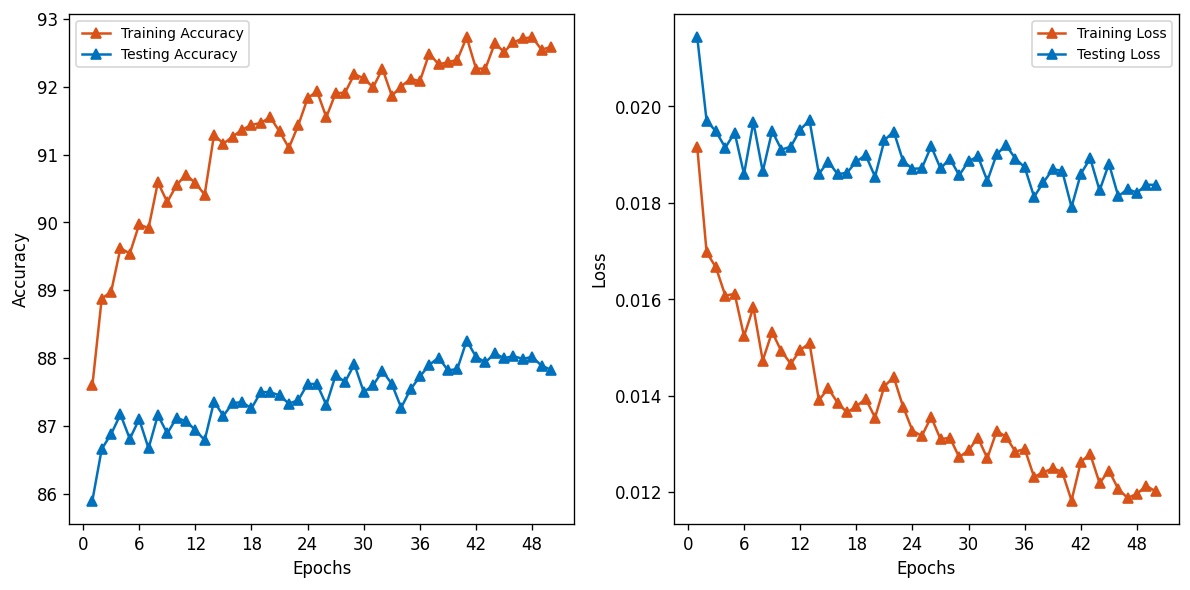

Max training accuracy: 92.73% at epoch 41
Max testing accuracy:  88.26% at epoch 41
Min training loss:     0.011827434317876275 at epoch 41
Min testing loss:      0.017912929011776615 at epoch 41


In [14]:
plot_train_test_acc_loss(train_acc2, test_acc2, train_loss2, test_loss2)
print(f"Max training accuracy: {max(train_acc2):2.2f}% at epoch {np.argmax(train_acc2)+1}")
print(f"Max testing accuracy:  {max(test_acc2):2.2f}% at epoch {np.argmax(test_acc2)+1}")
print(f"Min training loss:     {min(train_loss2)} at epoch {np.argmin(train_loss2)+1}")
print(f"Min testing loss:      {min(test_loss2)} at epoch {np.argmin(test_loss2)+1}")

Recalling the first model's accuracy and loss:

```text
Max training accuracy: 94.09% at epoch 47
Max testing accuracy:  88.50% at epoch 50
Min training loss:     0.009332795268898674 at epoch 50
Min testing loss:      0.017740105328257212 at epoch 47
```

We see that this model did comparably well! Let's look at what the predictions of this model were:

Training data sample (not preprocessed for resnet):


/tmp/ipykernel_2074/2214116611.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  label = np.vstack(res)


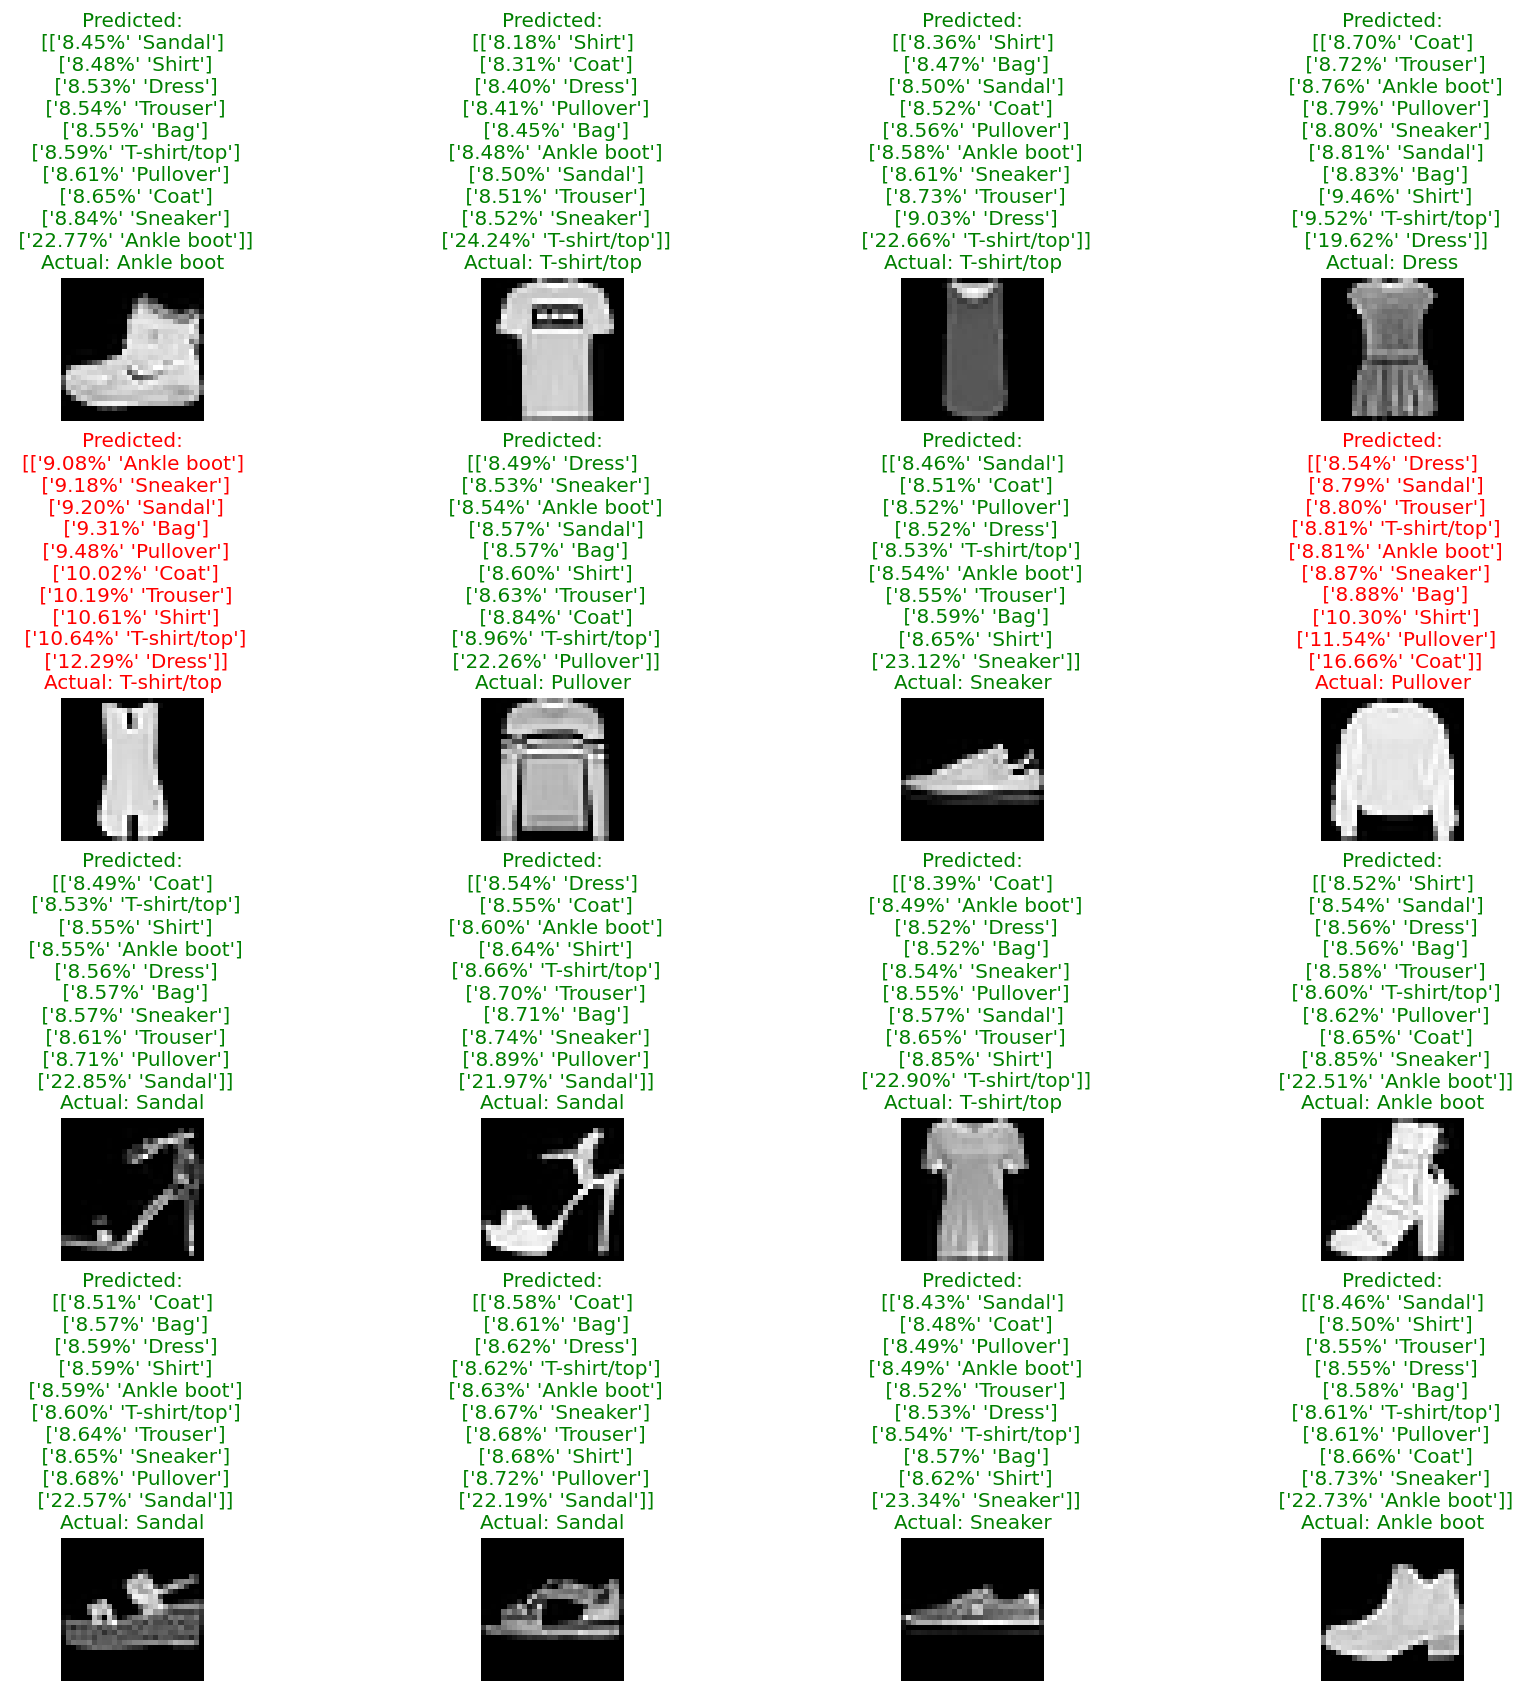

In [15]:
# Plot training data sample
print("Training data sample (not preprocessed for resnet):")
batch = next(iter(train_dl1))

# Create our figure as a grid
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(3.5*ncols,3.5*nrows), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
            image = batch[0][r*ncols+c]
            label_real = batch[1][r*ncols+c]
            label_real = model2.labels[label_real.item()]
            image_show = permute(image, (1,2,0)) # Change ordering of dimensions

            with torch.no_grad():
                res = model2.get_labels_acc(image.to(device))
                res = map(lambda tup: (f"{tup[0]:2.2f}%", tup[1]), res)
                label = np.vstack(res)

            ax = f1_axes[r][c]
            ax.set_axis_off()
            ax.set_title("Predicted:\n" + str(label) + f"\nActual: {label_real:s}",
                        fontdict = {'color': 'green' if label_real == label[-1][1] else 'red'})
            ax.imshow(np.asarray(image_show), cmap='gray')

plt.show()

Here, I would have expected both the predictions and the order of the predictions to be very similar. In reality, sometimes the smaller model didn't make the same predictions as the larger model. When those predictions were the same, they didn't always have the same order to them. However, sometimes the predictions and the orders were very similar. This is likely a result of the smaller model just not having the same number of parameters as the larger model, so they can't make the exact same predictions in all cases. Lets retrain this smaller model but use the original, true labels during training and see what we get.

In [16]:
model3 = NeuralNetwork2().to(device)

In [17]:
# Make our optimizer
loss_fn3 = nn.MSELoss() # MSE Loss since it supports one-hot encoding
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=learning_rate) # AdamW since it's faster than SGD

In [ ]:
train_acc3 = list()
test_acc3 = list()
train_loss3 = list()
test_loss3 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train_loop(train_dl2, model3, loss_fn3, optimizer3)
    
    acc, loss = test_loop(train_dl2, model3, loss_fn3)
    train_acc3.append(acc)
    train_loss3.append(loss)
    
    acc, loss = test_loop(test_dl2, model3, loss_fn3)
    test_acc3.append(acc)
    test_loss3.append(loss)
print("Done!")

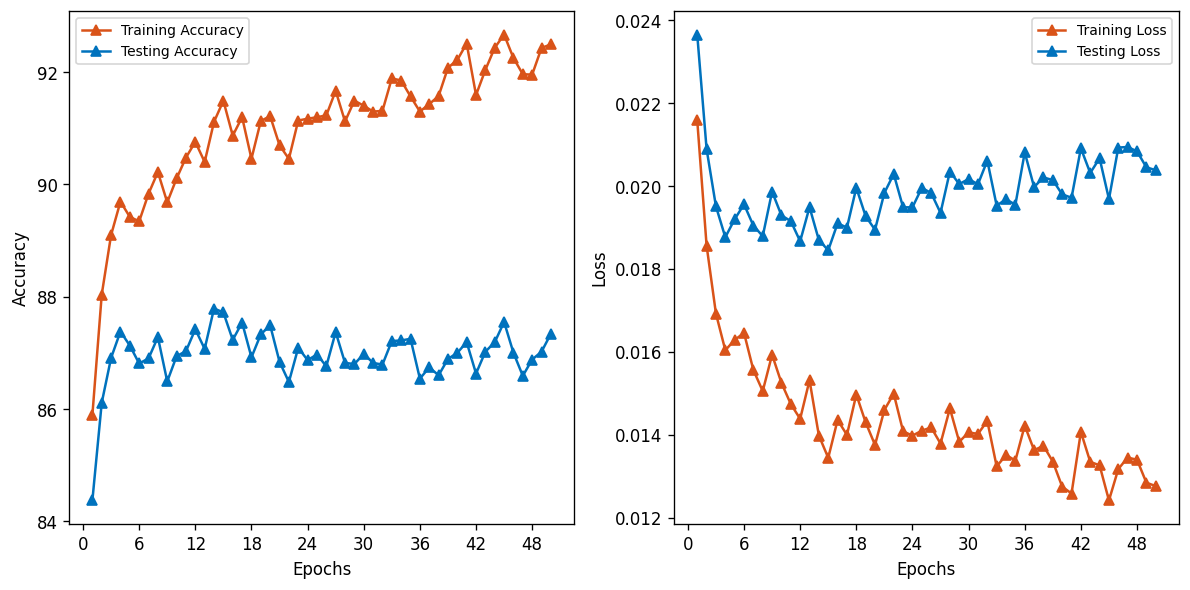

Max training accuracy: 92.66% at epoch 45
Max testing accuracy:  87.79% at epoch 14
Min training loss:     0.012413556919309 at epoch 45
Min testing loss:      0.018447228658277862 at epoch 15


In [19]:
plot_train_test_acc_loss(train_acc3, test_acc3, train_loss3, test_loss3)
print(f"Max training accuracy: {max(train_acc3):2.2f}% at epoch {np.argmax(train_acc3)+1}")
print(f"Max testing accuracy:  {max(test_acc3):2.2f}% at epoch {np.argmax(test_acc3)+1}")
print(f"Min training loss:     {min(train_loss3)} at epoch {np.argmin(train_loss3)+1}")
print(f"Min testing loss:      {min(test_loss3)} at epoch {np.argmin(test_loss3)+1}")

Recalling the first model's accuracy and loss:

```
Max training accuracy: 94.09% at epoch 47
Max testing accuracy:  88.50% at epoch 50
Min training loss:     0.009332795268898674 at epoch 50
Min testing loss:      0.017740105328257212 at epoch 47
```

Recalling the knowledge distilled model's accuracy and loss:

```
Max training accuracy: 92.73% at epoch 41
Max testing accuracy:  88.26% at epoch 41
Min training loss:     0.011827434317876275 at epoch 41
Min testing loss:      0.017912929011776615 at epoch 41
```

We see that the non-knowledge distilled small model did comparable to the knowledge-distilled counterpart. I speculate that the reason knowledge distillation didn't do better is because we're using MLPs. Knowledge distillation makes sense intuitively if we think of convolutions: when training on images the large model learns various features of its inputs. The larger model learns the difference between a T-shirt and a dress in a much finer way than a smaller model can. Knowledge distillation then teaches the smaller model using this extra information, making the smaller model better trained for the same number of epochs than if the smaller model just used the original data.

For our MLP example we aren't using convolutions, so the learned weights are much more of a "black-box" than the kernels of a convolutional neural network. The below image supports this conclusion since the same model trained on the original data has a much different ordering of probabilities for input images than the knowledge-distilled model:

Training data sample (not preprocessed for resnet):


/tmp/ipykernel_2074/126776541.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  label = np.vstack(res)


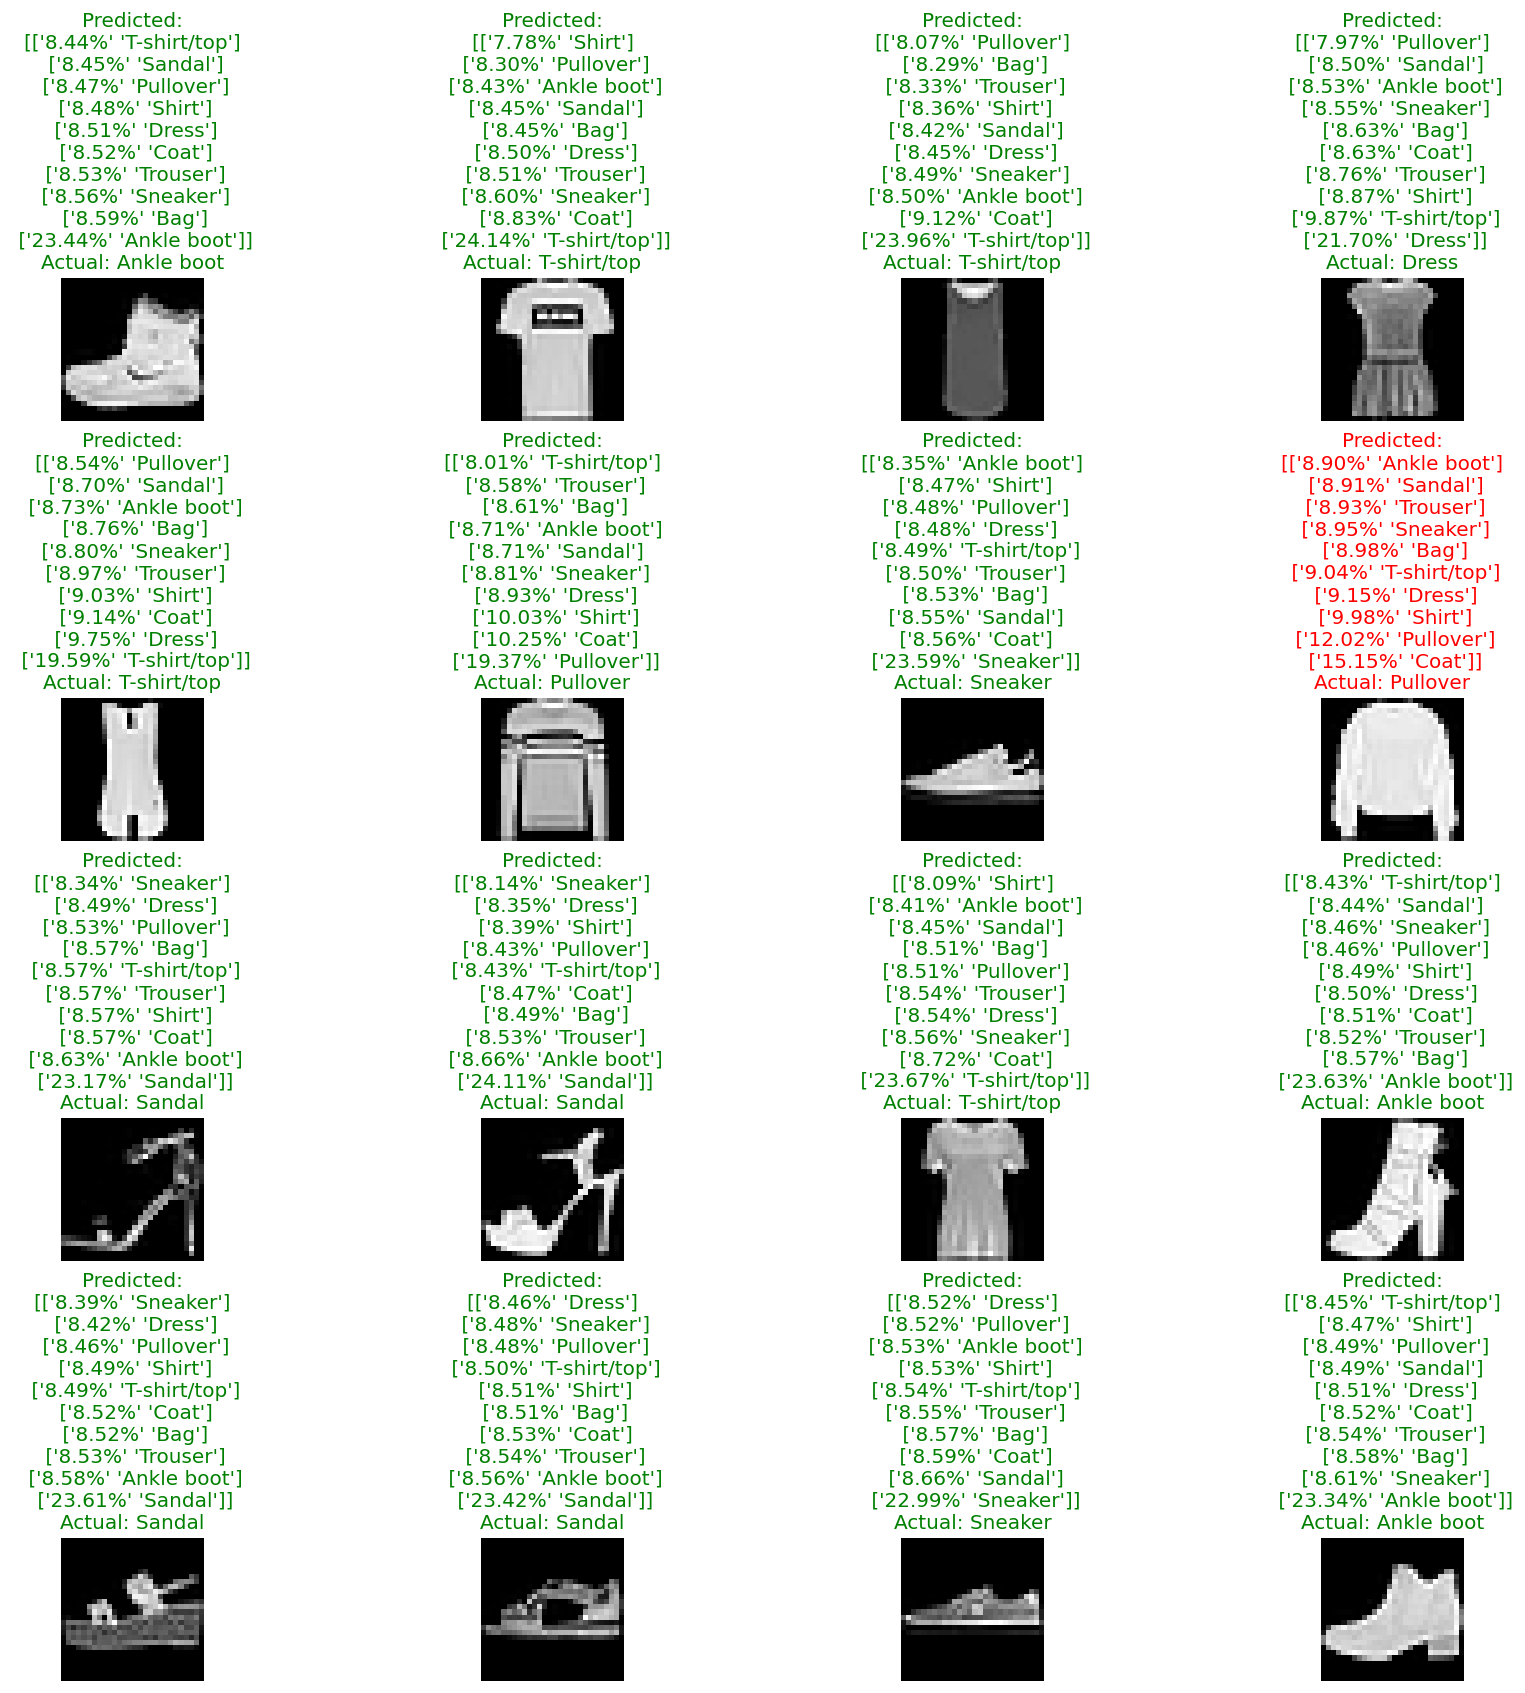

In [20]:
# Plot training data sample
print("Training data sample (not preprocessed for resnet):")
batch = next(iter(train_dl1))

# Create our figure as a grid
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(3.5*ncols,3.5*nrows), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
            image = batch[0][r*ncols+c]
            label_real = batch[1][r*ncols+c]
            label_real = model3.labels[label_real.item()]
            image_show = permute(image, (1,2,0)) # Change ordering of dimensions

            with torch.no_grad():
                res = model3.get_labels_acc(image.to(device))
                res = map(lambda tup: (f"{tup[0]:2.2f}%", tup[1]), res)
                label = np.vstack(res)

            ax = f1_axes[r][c]
            ax.set_axis_off()
            ax.set_title("Predicted:\n" + str(label) + f"\nActual: {label_real:s}",
                        fontdict = {'color': 'green' if label_real == label[-1][1] else 'red'})
            ax.imshow(np.asarray(image_show), cmap='gray')

plt.show()

I'll now explore how knowledge distillation works with convolutional neural networks.